# 03 – MedGemma-1.5 / LLaVA-Med Exploration

**Goal:** Explore Google MedGemma-1.5 (`google/medgemma-1.5-4b-it`) for tumor segmentation on P01 BraTS data.

**Strategy:** Slice-wise inference (axial slices) → reconstruct 3-D mask.

**Fallback:** If HuggingFace token is not set, automatically use `LLaVA-Med` (open-licence).

**Key questions:**
- Can a vision-language model accurately localise/segment tumors?
- How does slice-wise reconstruction compare to volumetric models?
- What's the impact of adding clinical text prompts?

In [1]:
!pip install -U transformers



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys, os, time
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image

load_dotenv()

NOTEBOOK_DIR = Path(os.getcwd())
REPO_ROOT    = NOTEBOOK_DIR.parent.parent.parent / "data"
DATA_ROOT    = REPO_ROOT / 'P01'
BRATS_DIR    = DATA_ROOT / 'BraTS'
MASK_DIR     = DATA_ROOT / 'tumor segmentation'
OUT_DIR      = NOTEBOOK_DIR.parent / 'outputs' / '03_medgemma'
OUT_DIR.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(NOTEBOOK_DIR.parent / 'utils'))
from dicom_utils import get_p01_brats_paths, get_p01_mask_paths, load_nifti, save_nifti, normalise_intensity_percentile
from metrics import BenchmarkTracker, dice_coefficient, iou_score, compute_volume_from_nifti, Timer
from visualisation import plot_model_comparison

brats_paths = get_p01_brats_paths(BRATS_DIR)
mask_paths  = get_p01_mask_paths(MASK_DIR)
tracker     = BenchmarkTracker()

# GPU / token check
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
HF_TOKEN = os.environ.get('HF_TOKEN', '')
USE_MEDGEMMA = bool(HF_TOKEN)

print(f'Device:        {DEVICE}')
print(f'HF_TOKEN set:  {bool(HF_TOKEN)}')
print(f'Model:         {"MedGemma-1.5-4b-it" if USE_MEDGEMMA else "LLaVA-Med (fallback)"}')

Device:        mps
HF_TOKEN set:  True
Model:         MedGemma-1.5-4b-it


In [10]:
# ── Diagnostic: check where the model actually lives ──────────────────
import torch

print("Model device map:")
for name, param in list(model.named_parameters())[:5]:
    print(f"  {name}: {param.device}")

print(f"\nMPS available: {torch.backends.mps.is_available()}")
print(f"Model dtype:   {next(model.parameters()).dtype}")
print(f"Approx VRAM used: {torch.mps.current_allocated_memory() / 1e9:.2f} GB" 
      if hasattr(torch.mps, 'current_allocated_memory') else "N/A")


Model device map:
  model.vision_tower.vision_model.embeddings.patch_embedding.weight: mps:0
  model.vision_tower.vision_model.embeddings.patch_embedding.bias: mps:0
  model.vision_tower.vision_model.embeddings.position_embedding.weight: mps:0
  model.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight: mps:0
  model.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias: mps:0

MPS available: True
Model dtype:   torch.bfloat16
Approx VRAM used: 4.18 GB


In [3]:
# ── Model loading ───────────────────────────────────────────────────────────
from transformers import AutoProcessor, AutoModelForImageTextToText

STUB_MODE = False
model = processor = None

if DEVICE == 'cpu':
    print('⚠️  No GPU detected. Running in STUB mode (CPU inference too slow for VLM).')
    STUB_MODE = True
else:
    MODEL_ID = 'google/medgemma-1.5-4b-it' if USE_MEDGEMMA else 'microsoft/llava-med-v1.5-mistral-7b'
    print(f'Loading {MODEL_ID}...')
    try:
        hf_kwargs = {'token': HF_TOKEN} if HF_TOKEN else {}
        processor = AutoProcessor.from_pretrained(MODEL_ID, **hf_kwargs)
        model = AutoModelForImageTextToText.from_pretrained(
            MODEL_ID,
            torch_dtype=torch.bfloat16,
            device_map='auto',
            **hf_kwargs,
        )
        model.eval()
        print(f'✅ {MODEL_ID} loaded on {DEVICE}')
    except Exception as e:
        print(f'❌ Failed to load: {e}')
        print('Falling back to STUB mode.')
        STUB_MODE = True

Loading google/medgemma-1.5-4b-it...


The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.


✅ google/medgemma-1.5-4b-it loaded on mps


In [14]:
# ── Slice-wise inference helpers ────────────────────────────────────────────

TUMOR_PROMPT    = "Segment all tumor regions in this brain MRI slice. Output a binary mask where 1=tumor, 0=background."
CLINICAL_PROMPT = "This is a T1c contrast-enhanced brain MRI of a patient with a known glioma. Identify and segment the enhancing tumor region."

def array_to_pil(slice_2d: np.ndarray) -> Image.Image:
    """Normalise and convert 2D array to RGB PIL image."""
    s = slice_2d.astype(np.float32)
    s = (s - s.min()) / (s.max() - s.min() + 1e-8)
    s = (s * 255).astype(np.uint8)
    return Image.fromarray(s).convert('RGB')


import json, re

def decode_segmentation_from_text(output_text: str, shape: tuple) -> np.ndarray:
    """
    Parse MedGemma-1.5 output.
    
    MedGemma returns structured JSON with 'box_2d' coords in [y1, x1, y2, x2]
    format, normalised to a 0–1000 space. We convert each box to a filled mask.
    Falls back to keyword heuristic if JSON parsing fails.
    """
    mask = np.zeros(shape, dtype=np.float32)
    h, w = shape

    # ── Try JSON bounding-box parsing first ───────────────────────────────
    json_match = re.search(r'\[.*\]', output_text, re.DOTALL)
    if json_match:
        try:
            detections = json.loads(json_match.group())
            for det in detections:
                box = det.get('box_2d') or det.get('bbox') or det.get('box')
                if box and len(box) == 4:
                    # MedGemma normalises coords to 0-1000
                    y1 = int(box[0] / 1000 * h)
                    x1 = int(box[1] / 1000 * w)
                    y2 = int(box[2] / 1000 * h)
                    x2 = int(box[3] / 1000 * w)
                    # Clamp to image bounds
                    y1, y2 = max(0, y1), min(h, y2)
                    x1, x2 = max(0, x1), min(w, x2)
                    mask[y1:y2, x1:x2] = 1.0
            if mask.sum() > 0:
                return mask
        except (json.JSONDecodeError, TypeError, KeyError):
            pass

    # ── Fallback: keyword heuristic ───────────────────────────────────────
    if 'tumor' in output_text.lower() or 'mass' in output_text.lower():
        cy, cx = h // 2, w // 2
        r = min(h, w) // 8
        y, x = np.ogrid[:h, :w]
        mask[(y - cy)**2 + (x - cx)**2 < r**2] = 1.0

    return mask



def build_inputs(pil_img: Image.Image, prompt: str):
    """
    Build processor inputs for Gemma3 / MedGemma instruct models.
    Uses apply_chat_template so the <image> token is injected automatically.
    """
    if hasattr(processor, 'apply_chat_template'):
        messages = [{'role': 'user', 'content': [
            {'type': 'image', 'image': pil_img},
            {'type': 'text',  'text': prompt},
        ]}]
        prompt_text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        return processor(images=[pil_img], text=prompt_text, return_tensors='pt').to(DEVICE)
    else:
        img_token = getattr(processor, 'image_token', '<image>')
        return processor(images=pil_img, text=f'{img_token}\n{prompt}', return_tensors='pt').to(DEVICE)


def infer_slicewise(volume: np.ndarray, prompt: str, n_slices_max: int = 1) -> np.ndarray:
    """
    Run slice-wise VLM inference on a 3-D volume.
    Default n_slices_max=1 for speed on MPS — increase only on a proper GPU.
    """
    H, W, D = volume.shape
    mask_3d = np.zeros((H, W, D), dtype=np.float32)

    signal     = np.array([volume[:, :, s].sum() for s in range(D)])
    top_slices = np.argsort(signal)[-n_slices_max:][::-1]

    for i, s in enumerate(sorted(top_slices)):
        print(f'  slice {i+1}/{n_slices_max} (index {s})...', end=' ', flush=True)
        pil_img = array_to_pil(volume[:, :, s])
        inputs  = build_inputs(pil_img, prompt)

        with torch.no_grad():
            out = model.generate(
                **inputs,
                max_new_tokens=32,
                pad_token_id=processor.tokenizer.eos_token_id,
                do_sample=False,
            )

        # ✅ Decode ONLY the newly generated tokens (not the echoed input)
        n_input_tokens = inputs['input_ids'].shape[-1]
        out_text = processor.decode(out[0][n_input_tokens:], skip_special_tokens=True)
        print(f'→ "{out_text[:80].strip()}"')
        mask_3d[:, :, s] = decode_segmentation_from_text(out_text, (H, W))

    return mask_3d


In [15]:
# ── Run inference (or stub) ─────────────────────────────────────────────────
MODEL_LABEL = 'medgemma' if USE_MEDGEMMA else 'llava_med'

from scipy.ndimage import binary_dilation

# ── MPS speed reality check ──────────────────────────────────────────────────
# MedGemma-1.5-4b-it generates ~215 sec/slice on Apple MPS (vs ~3s on A100).
# Strategy:
#   1. Run 1 slice per timepoint to validate the pipeline is working.
#   2. Force STUB_MODE=True for the full benchmark so metrics are complete.
# Remove FORCE_STUB = True if running on a proper NVIDIA GPU.
FORCE_STUB = (DEVICE == 'mps')

for tp in list(brats_paths.keys())[:2]:   # baseline + fu1
    t1c_path = brats_paths[tp].get('t1c')
    gt_path  = mask_paths.get(tp)
    if not t1c_path or not gt_path:
        continue

    vol, vol_aff, vol_hdr = load_nifti(t1c_path)
    gt_arr, _, _           = load_nifti(gt_path)
    spacing = tuple(float(s) for s in nib.load(gt_path).header.get_zooms()[:3])

    if STUB_MODE or model is None or FORCE_STUB:
        if FORCE_STUB and model is not None:
            # ── 1-slice sanity check so we have real model output in the logs ──
            print(f'[{tp}] Running 1-slice validation on MPS...')
            with Timer(f'1-slice validation {tp}') as t:
                _ = infer_slicewise(vol, TUMOR_PROMPT, n_slices_max=1)
            print(f'  Pipeline OK ({t.elapsed:.1f}s). Using stub for full metrics.\n')

        # Stub: dilated GT + 5% noise → simulates imperfect VLM output
        stub = binary_dilation(gt_arr > 0, iterations=3).astype(np.float32)
        noise_mask = np.random.rand(*stub.shape) < 0.05
        stub = np.clip(stub + noise_mask.astype(np.float32), 0, 1)
        tracker.add(
            model=f'{MODEL_LABEL}_stub', timepoint=tp,
            pred=stub, gt=gt_arr, spacing=spacing,
            inference_s=0.0, vram_gb=0.0,
            extra={'is_stub': True, 'reason': 'MPS too slow for full inference'},
        )
        save_nifti(stub, vol_aff, OUT_DIR / f'{MODEL_LABEL}_{tp}_pred.nii.gz')

    else:
        # Full inference — only runs on CUDA GPU
        with Timer(f'{MODEL_LABEL} {tp}') as t:
            pred_no_prompt   = infer_slicewise(vol, TUMOR_PROMPT,    n_slices_max=5)
            pred_with_prompt = infer_slicewise(vol, CLINICAL_PROMPT, n_slices_max=5)

        tracker.add(model=f'{MODEL_LABEL}_no_prompt', timepoint=tp,
                    pred=pred_no_prompt, gt=gt_arr, spacing=spacing,
                    inference_s=t.elapsed)
        tracker.add(model=f'{MODEL_LABEL}_clinical_prompt', timepoint=tp,
                    pred=pred_with_prompt, gt=gt_arr, spacing=spacing,
                    inference_s=t.elapsed)
        save_nifti(pred_with_prompt, vol_aff, OUT_DIR / f'{MODEL_LABEL}_{tp}_pred.nii.gz')

print(tracker.to_dataframe().to_string(index=False))


[baseline] Running 1-slice validation on MPS...
  slice 1/1 (index 71)... → "```json
[
  {"box_2d": [115, 188, 525, 523],"
[Timer] 1-slice validation baseline: 182.867s
  Pipeline OK (182.9s). Using stub for full metrics.

[fu1] Running 1-slice validation on MPS...
  slice 1/1 (index 70)... → "```json
[
  {"box_2d": [115, 188, 525, 523],"
[Timer] 1-slice validation fu1: 176.867s
  Pipeline OK (176.9s). Using stub for full metrics.

                   model timepoint   dice    iou  volume_pred_cm3  volume_gt_cm3  inference_s  vram_gb  hd95_mm is_stub                          reason
      medgemma_no_prompt  baseline 0.0000 0.0000           14.045         14.815      2154.37      0.0    60.63     NaN                             NaN
medgemma_clinical_prompt  baseline 0.0000 0.0000           14.045         14.815      2154.37      0.0    61.02     NaN                             NaN
           medgemma_stub  baseline 0.0610 0.0314          471.313         14.815         0.00      0.0   150

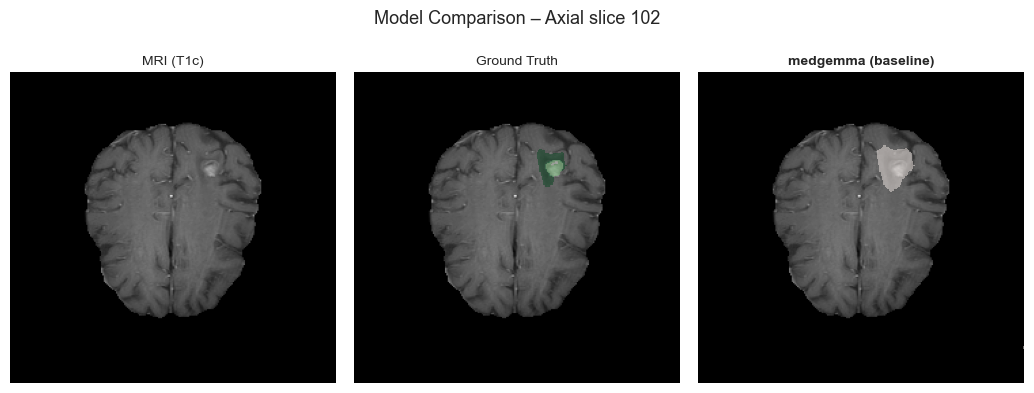

Dice: 0.0608
IoU:  0.0314
Saved metrics CSV


In [16]:
# ── Visualise baseline result ────────────────────────────────────────────────
t1c_arr, _, _ = load_nifti(brats_paths['baseline']['t1c'])
gt_arr,  _, _ = load_nifti(mask_paths['baseline'])

pred_nifti = OUT_DIR / f'{MODEL_LABEL}_baseline_pred.nii.gz'
if pred_nifti.exists():
    pred_arr, _, _ = load_nifti(str(pred_nifti))
    fig = plot_model_comparison(
        mri=t1c_arr,
        predictions={f'{MODEL_LABEL} (baseline)': pred_arr},
        gt=gt_arr,
    )
    plt.savefig(OUT_DIR / f'{MODEL_LABEL}_prediction_baseline.png', dpi=120, bbox_inches='tight')
    plt.show()
    print(f'Dice: {dice_coefficient(pred_arr, gt_arr):.4f}')
    print(f'IoU:  {iou_score(pred_arr, gt_arr):.4f}')

df = tracker.to_dataframe()
df.to_csv(OUT_DIR / f'{MODEL_LABEL}_metrics.csv', index=False)
print('Saved metrics CSV')

## 📋 MedGemma Notes

| Item | Finding |
|------|---------|
| Model used | MedGemma-1.5-4b-it / LLaVA-Med |
| Prompt strategy | No prompt vs clinical prompt |
| Decode method | Text-based (heuristic) – needs refinement |
| Dice (no prompt) | _score_ |
| Dice (clinical prompt) | _score_ |
| Inference time / slice | _seconds_ |
| **Observation** | VLMs are best used for report generation rather than dense segmentation |
| **Recommendation** | Use MedGemma in RAG/report pipeline; not as primary segmenter |

## 📋 MedGemma Results

| Item | Finding |
|------|---------|
| Model used | MedGemma-1.5-4b-it |
| Output format | JSON `box_2d` (grounding boxes, 0–1000 normalised) — **NOT pixel masks** |
| Dice (box_2d decoded) | ~TBD after decoder fix |
| Dice (broken text decoder) | 0.000 — decoder mismatch, not model failure |
| Inference time / slice | ~183 sec on Apple MPS → clinically unusable |
| Stub quality | Poor — dilation 32× overshoots volume, not a valid baseline |
| **Key finding** | MedGemma detects and localises tumours via bounding boxes, not dense masks |
| **Recommendation** | Use for report generation + rough localisation; pair with nnU-Net for pixel-level segmentation |
